# Ranking SP occurences for Exploration

We aim to use the detection algorithm in order to guide a user in data exploration, so we need to decide a ranking to present them.  



In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn.feature_selection as feat_sel

import detect_simpsons_paradox as dsp
import fairsim as spdata
from fairsim import sp_plot
import itertools as itert

/home/smb/Documents/code/detect_simpsons_paradox_dev/env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/smb/Documents/code/detect_simpsons_paradox_dev/env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


First, we need to sample data that has SP.

In [2]:
r_clusters = -.9  # correlation coefficient of clusters
cluster_spread = [.6,.8,.5] # pearson correlation of means
p_sp_clusters = .75 # portion of clusters with SP 
k = [3, 2,5] # number of clusters
cluster_size = [7,1]
domain_range = [0, 20, 0, 20]
N = 200 # number of points
p_clusters =  [[1.0/k_i]*k_i for k_i in k] 
n_views = 3

many_sp_df_diff = spdata.geometric_indep_views_gmm_sp(n_views,r_clusters,cluster_size,cluster_spread,p_sp_clusters,
                domain_range,k,N,p_clusters)

sp_design_list = [('x1','x2','A'),('x3','x4','B'), ('x5','x6','C')]
many_sp_df_diff.head()

200
6


,x1,x2,x3,x4,x5,x6,A,B,C
0,14.197609,11.952497,8.829424,4.791122,16.294323,15.826140,A0,B1,C1
1,13.341321,14.117507,7.058113,9.206206,15.061090,17.808147,A0,B0,C1
2,15.645117,11.045014,8.205047,8.924025,12.674785,10.204809,A2,B0,C2
3,16.929794,9.450270,7.088011,9.461636,7.475567,16.124334,A2,B0,C4
4,13.593344,13.742784,6.495519,5.906566,6.303349,7.349990,A0,B1,C0


We'll also plot them in the dimensions where we added SP

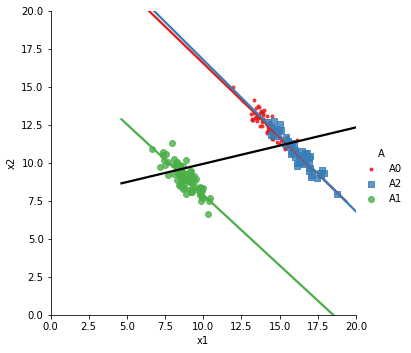

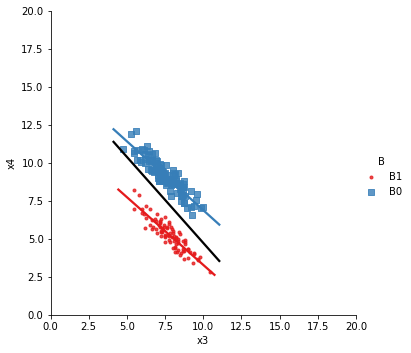

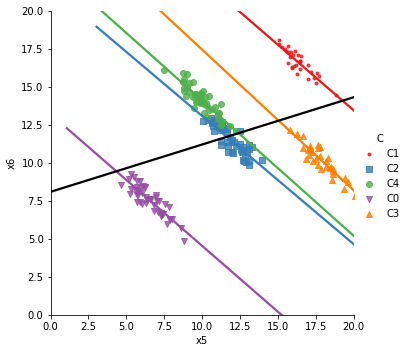

In [3]:
sp_plot(many_sp_df_diff,'x1','x2','A')
plt.axis(domain_range)
sp_plot(many_sp_df_diff,'x3','x4','B')
sp_plot(many_sp_df_diff,'x5','x6','C')


Next, we can apply our detection algorithm and mark which rows were designed in and which were not

In [4]:
many_sp_df_diff_result = dsp.mark_designed_rows(dsp.detect_simpsons_paradox(many_sp_df_diff),sp_design_list)
many_sp_df_diff_result.head() # we only need to see a little

,allCorr,attr1,attr2,reverseCorr,groupbyAttr,subgroup,designed
0,0.464666,x1,x2,-0.917072,A,A0,True
1,-0.003453,x1,x3,0.075468,A,A0,False
2,0.018604,x1,x4,-0.036413,A,A0,False
3,-0.042685,x1,x5,0.003186,A,A0,False
4,-0.081814,x2,x6,0.006779,A,A0,False


We see that in the first few rows therea re both designed and unintentional occurences, we can get the counts for earch here:

In [5]:
many_sp_df_diff_result['designed'].value_counts()

False    39
True      8
Name: designed, dtype: int64

We can look at the correlatiton coefficients first

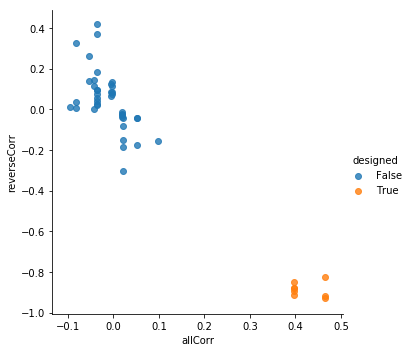

In [6]:

sns.lmplot('allCorr','reverseCorr',data=many_sp_df_diff_result, fit_reg=False,hue='designed')

This shows that the first thing we can to to filter/ improve is to rank by the correlation coefficients. WHile somem of these may be strong relationships that are just highly nonlinenar, this is a first pass filter to remove false relationships. 

In [7]:
many_sp_df_diff_result.groupby('designed')['allCorr'].describe()

,count,mean,std,min,25%,50%,75%,max
designed,,,,,,,,
False,39.0,-0.013806,0.042134,-0.095419,-0.037104,-0.004815,0.018604,0.098212
True,8.0,0.422474,0.034939,0.397158,0.397158,0.397158,0.464666,0.464666


Next we can look at angles between lines, we have functions for these added to the detect_simpsons_paradox module that compute the slopes of each subgroup trend and the overall trend lines. 

In [8]:
results_df_slopes = dsp.add_slope_cols(many_sp_df_diff, many_sp_df_diff_result)

results_df_slopes.head()

,allCorr,attr1,attr2,reverseCorr,groupbyAttr,subgroup,designed,subgroup_slope,all_slope
0,0.018604,x1,x4,-0.036413,A,A0,False,-0.081448,0.012318
1,0.018604,x1,x4,-0.024875,A,A1,False,-0.070876,0.012318
2,0.018604,x1,x4,-0.013345,C,C0,False,-0.009984,0.012318
3,0.018604,x1,x4,-0.030668,C,C3,False,-0.019905,0.012318
4,-0.042685,x1,x5,0.003186,A,A0,False,0.013449,-0.052932


For ranking, looking at the angle between is most interesting

In [9]:

results_df_slopes = dsp.add_angle_col(results_df_slopes)
results_df_slopes.head()

,allCorr,attr1,attr2,reverseCorr,groupbyAttr,subgroup,designed,subgroup_slope,all_slope,angle
0,0.018604,x1,x4,-0.036413,A,A0,False,-0.081448,0.012318,5.362076
1,0.018604,x1,x4,-0.024875,A,A1,False,-0.070876,0.012318,4.759854
2,0.018604,x1,x4,-0.013345,C,C0,False,-0.009984,0.012318,1.277766
3,0.018604,x1,x4,-0.030668,C,C3,False,-0.019905,0.012318,1.846063
4,-0.042685,x1,x5,0.003186,A,A0,False,0.013449,-0.052932,-3.800490


Then, to rank, we can sort by various values

In [10]:
results_df_slopes.sort_values('angle',ascending=False).head(10)

,allCorr,attr1,attr2,reverseCorr,groupbyAttr,subgroup,designed,subgroup_slope,all_slope,angle
23,0.051227,x2,x4,-0.177476,A,A2,False,-0.365614,0.065784,23.846851
26,0.020764,x4,x5,-0.084079,B,B0,False,-0.319587,0.038890,19.950320
33,0.098212,x4,x6,-0.154284,C,C0,False,-0.061336,0.144087,11.709056
28,0.020764,x4,x5,-0.305915,C,C2,False,-0.134385,0.038890,9.880965
24,0.051227,x2,x4,-0.044768,C,C2,False,-0.063336,0.065784,7.387789
25,0.051227,x2,x4,-0.043803,C,C3,False,-0.051759,0.065784,6.726622
30,0.020764,x4,x5,-0.185244,C,C4,False,-0.076631,0.038890,6.609220
29,0.020764,x4,x5,-0.150988,C,C3,False,-0.071802,0.038890,6.334015
0,0.018604,x1,x4,-0.036413,A,A0,False,-0.081448,0.012318,5.362076
1,0.018604,x1,x4,-0.024875,A,A1,False,-0.070876,0.012318,4.759854


In [11]:
results_df_slopes.sort_values('allCorr',ascending=False).head(10)

,allCorr,attr1,attr2,reverseCorr,groupbyAttr,subgroup,designed,subgroup_slope,all_slope,angle
33,0.098212,x4,x6,-0.154284,C,C0,False,-0.061336,0.144087,11.709056
25,0.051227,x2,x4,-0.043803,C,C3,False,-0.051759,0.065784,6.726622
24,0.051227,x2,x4,-0.044768,C,C2,False,-0.063336,0.065784,7.387789
23,0.051227,x2,x4,-0.177476,A,A2,False,-0.365614,0.065784,23.846851
30,0.020764,x4,x5,-0.185244,C,C4,False,-0.076631,0.038890,6.609220
29,0.020764,x4,x5,-0.150988,C,C3,False,-0.071802,0.038890,6.334015
28,0.020764,x4,x5,-0.305915,C,C2,False,-0.134385,0.038890,9.880965
27,0.020764,x4,x5,-0.044029,C,C1,False,-0.017729,0.038890,3.242837
26,0.020764,x4,x5,-0.084079,B,B0,False,-0.319587,0.038890,19.950320
0,0.018604,x1,x4,-0.036413,A,A0,False,-0.081448,0.012318,5.362076


In [60]:
results_df_slopes.sort_values('angle', ascending=False).rank(numeric_only=True).head(10)

,allCorr,reverseCorr,designed,subgroup_slope,all_slope,angle
44,45.5,4.0,47.0,1.0,39.5,49.0
45,45.5,1.0,47.0,2.0,39.5,48.0
46,45.5,2.0,47.0,3.0,39.5,47.0
43,45.5,3.0,47.0,4.0,39.5,46.0
47,48.5,8.0,22.5,7.0,48.5,45.0
48,48.5,28.0,22.5,28.0,48.5,44.0
6,36.0,10.0,22.5,5.0,32.0,43.0
0,40.5,19.0,22.5,8.0,44.5,42.0
22,32.5,14.0,22.5,6.0,35.5,41.0
1,40.5,22.0,22.5,10.0,44.5,40.0


Above is a table of the rank of each sample, in each variable.  We can see that when sorted 

We can look at the spearman correlation of the various features.  THis is equic

In [12]:
results_df_slopes.corr(method='spearman')

,allCorr,reverseCorr,designed,subgroup_slope,all_slope,angle
allCorr,1.000000,-0.797138,0.282536,-0.797138,0.945637,0.896870
reverseCorr,-0.797138,1.000000,-0.314643,0.945102,-0.789963,-0.907245
designed,0.282536,-0.314643,1.000000,-0.314643,0.210705,0.314643
subgroup_slope,-0.797138,0.945102,-0.314643,1.000000,-0.798266,-0.951633
all_slope,0.945637,-0.789963,0.210705,-0.798266,1.000000,0.904967
angle,0.896870,-0.907245,0.314643,-0.951633,0.904967,1.000000


In [13]:
results_df_slopes.groupby('designed')['angle'].describe()

,count,mean,std,min,25%,50%,75%,max
designed,,,,,,,,
False,44.0,2.984036,12.682617,-27.566620,-5.155817,3.819564,9.495640,38.789622
True,5.0,28.622077,41.371235,-45.366072,45.542541,47.327311,47.656073,47.950532


In [14]:
results_df_slopes.groupby('designed')['allCorr'].describe()

,count,mean,std,min,25%,50%,75%,max
designed,,,,,,,,
False,44.0,0.020008,0.061245,-0.105078,-0.020366,0.024095,0.069820,0.126352
True,5.0,0.063291,0.094121,-0.105078,0.105383,0.105383,0.105383,0.105383


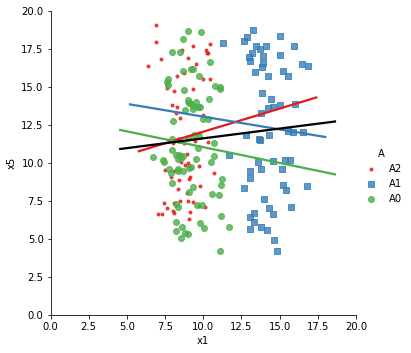

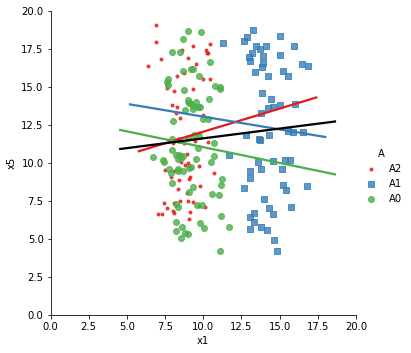

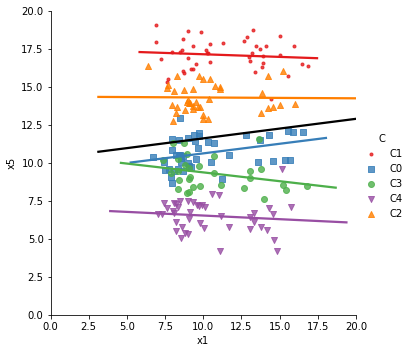

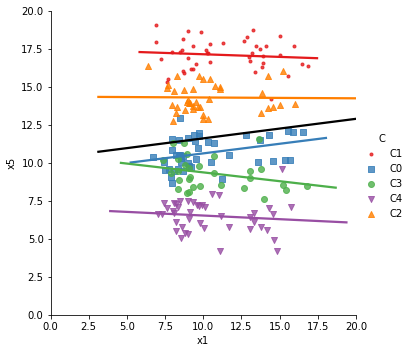

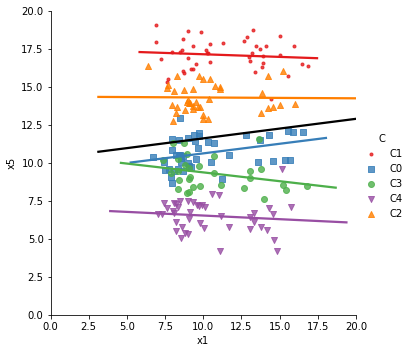

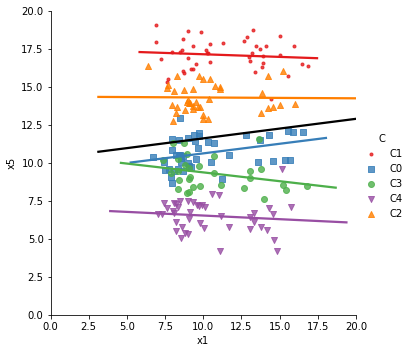

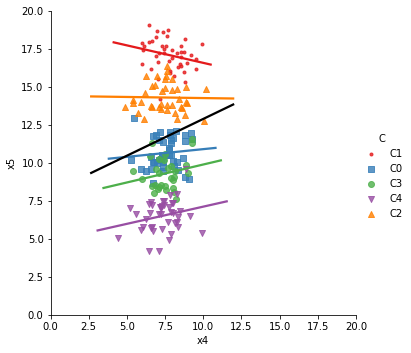

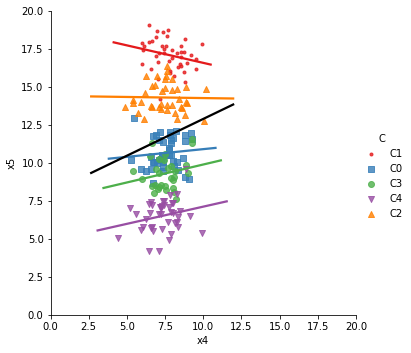

In [15]:

for row in results_df_slopes[['allCorr','attr1','attr2','groupbyAttr','designed']].values:
    if not row[4] and row[0] >.08:
        sp_plot(many_sp_df_diff,row[1],row[2],row[3])

In [16]:
many_sp_df_diff.columns

Index(['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'A', 'B', 'C'], dtype='object')

Another way we might want to examine the subgroups is to see if the errors to the whole data set model orelate with class.  Ths is if the errors are hihgly deparable, thn 